## House price prediction

In this notebook, we'll explore the Ames Housing dataset and use a tabular fully connected deep Neural Network. This type of Neural Networks are ideal to work with tabular data that contain continuous and categorical data. The data for the Ames housing can be found at the Kaggle competition: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import boxcox1p

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

### 1. Exploarory data analysis

In [2]:
df_train = pd.read_csv("Data/train.csv")
df_test = pd.read_csv("Data/test.csv")

# Split ID is 1461

df = pd.concat([df_train, df_test], axis=0)
df.reset_index(inplace=True, drop=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

#### Regressed variable

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23080\4143324588.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["SalePrice"])


<Axes: xlabel='SalePrice', ylabel='Density'>

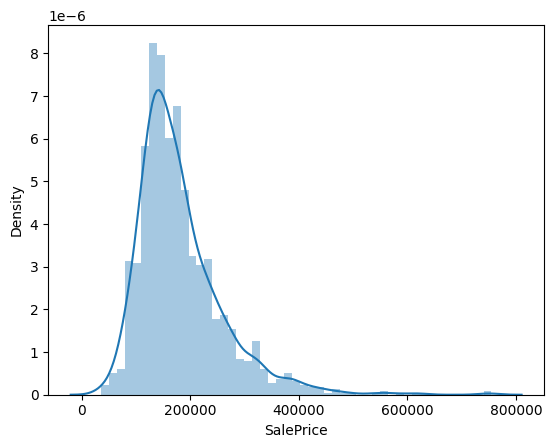

In [4]:
sns.distplot(df["SalePrice"])

The data looks like it's skewed more towards the smaller values. To fix this, we can use a log-transformation on the data. 

In [5]:
df["SalePrice"] = df.apply(lambda x: np.log(x["SalePrice"]) if pd.notnull(x["SalePrice"]) else np.nan, axis=1)


#### Overall data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [7]:
null_counts = df.isnull().sum()
null_counts_sorted = null_counts.sort_values(ascending=False)
null_counts_sorted[null_counts_sorted > 0]

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageCond       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
Functional         2
BsmtFullBath       2
Utilities          2
BsmtHalfBath       2
Electrical         1
TotalBsmtSF        1
BsmtUnfSF          1
KitchenQual        1
BsmtFinSF2         1
BsmtFinSF1         1
SaleType           1
GarageCars         1
Exterior2nd        1
Exterior1st        1
GarageArea         1
dtype: int64

For this case, sometimes the missing values are tricky in particular the ones with a lot, because the NA actually represents no

In [8]:
df["PoolQC"] = df["PoolQC"].fillna(value="No")
df["MiscFeature"] = df["MiscFeature"].fillna(value="No")
df["Alley"] = df["Alley"].fillna(value="No")
df["Fence"] = df["Fence"].fillna(value="No")
df["FireplaceQu"] = df["FireplaceQu"].fillna(value="No")

##### Continuous data

In [9]:
cont_cols = df.select_dtypes(exclude=['object']).columns
cont_cols = list(cont_cols)
cont_cols.remove("Id")
cont_cols.remove("SalePrice")


In [10]:
nunique_values = df[cont_cols].nunique()
summary_stats = df[cont_cols].describe().T
summary_stats['nunique'] = nunique_values
summary_stats

,count,mean,std,min,25%,50%,75%,max,nunique
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0,16
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0,128
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0,1951
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0,10
OverallCond,2919.0,5.564577,1.113131,1.0,5.0,5.0,6.0,9.0,9
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0,118
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1965.0,1993.0,2004.0,2010.0,61
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.0,0.0,164.0,1600.0,444
BsmtFinSF1,2918.0,441.423235,455.610826,0.0,0.0,368.5,733.0,5644.0,991
BsmtFinSF2,2918.0,49.582248,169.205611,0.0,0.0,0.0,0.0,1526.0,272


In [11]:
# Odd value in GarageYrBlt
odd_filt = df["GarageYrBlt"] > 2020

index = df[odd_filt].index
df.loc[index, 'GarageYrBlt'] = 2007

In [12]:
# Null values
null_counts = df[cont_cols].isnull().sum()
null_counts_sorted = null_counts.sort_values(ascending=False)
null_counts_sorted[null_counts_sorted > 0]

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
TotalBsmtSF       1
GarageCars        1
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
GarageArea        1
dtype: int64

**Filling the missing values by interpolation**

In [13]:
df["LotFrontage"] = df["LotFrontage"].interpolate(method='cubic', limit_direction='both')
df["GarageYrBlt"] = df["GarageYrBlt"].interpolate(method='cubic', limit_direction='both')

The MasVnrArea the same, no sense in replacing missing values by interpolation, the non-existance of the value indicates that it is not present, so an area of 0.

In [14]:
df["MasVnrArea"] = df["MasVnrArea"].fillna(value=0.0)

**Filling the missing values by mean values**

In [15]:
cols_mean_fill = ["BsmtHalfBath", "BsmtFullBath", "TotalBsmtSF", "GarageCars", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "GarageArea"]
imp1 = SimpleImputer(strategy="mean")
for cmf in cols_mean_fill:
    df[cmf] = imp1.fit_transform(df[[cmf]])


There are some continous columns that need to be classified as categories not continuous

In [16]:
not_conts = ["MSSubClass", 'OverallQual', 'OverallCond', "BsmtFullBath",\
     "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr",\
           "TotRmsAbvGrd", "Fireplaces", "GarageCars", "MoSold", "YrSold"]

label_encoder = LabelEncoder()
for col in not_conts:
    df[col] = label_encoder.fit_transform(df[col])
    df[col] = df[col].astype('category')

##### Categorical data

In [17]:
cat_cols = df_train.select_dtypes(['object']).columns
cat_cols

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [18]:
null_counts = df[cat_cols].isnull().sum()
null_counts_sorted = null_counts.sort_values(ascending=False)
null_counts_sorted[null_counts_sorted > 0] 

MasVnrType      1766
GarageCond       159
GarageQual       159
GarageFinish     159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MSZoning           4
Functional         2
Utilities          2
Electrical         1
SaleType           1
KitchenQual        1
Exterior1st        1
Exterior2nd        1
dtype: int64

In [19]:
df["GarageCond"] = df["GarageCond"].fillna(value="No")
df["GarageQual"] = df["GarageQual"].fillna(value="No")
df["GarageFinish"] = df["GarageFinish"].fillna(value="No")
df["GarageType"] = df["GarageType"].fillna(value="No")
df["BsmtExposure"] = df["BsmtExposure"].fillna(value="No")
df["BsmtCond"] = df["BsmtCond"].fillna(value="No")
df["BsmtQual"] = df["BsmtQual"].fillna(value="No")
df["BsmtFinType2"] = df["BsmtFinType2"].fillna(value="No")
df["BsmtFinType1"] = df["BsmtFinType1"].fillna(value="No")
df["MasVnrType"] = df["MasVnrType"].fillna(value="No")

In [20]:
cols_most_freq_fill = ["MSZoning", "Utilities", "Functional", "SaleType", "Electrical", "KitchenQual"]
imp2 = SimpleImputer(strategy="most_frequent")
for cmff in cols_most_freq_fill:
    df[cmff] = imp2.fit_transform(df[[cmff]]).ravel()

In [21]:
for col in cat_cols:
    df[col] = label_encoder.fit_transform(df[col])
    df[col] = df[col].astype('category')

### 2. Deep Learning 
The implemented model demonstrates the capability to seamlessly handle both categorical and continuous variables. Leveraging this versatility, the data loader intelligently dissects the input data into distinct categories of categorical and continuous variables. Additionally, it dynamically calculates the embedding size, ensuring optimal utilization of resources and efficient representation of categorical data. This innovative approach empowers the model to efficiently process diverse types of input features, enhancing its flexibility and adaptability across various real-world scenarios.

#### Data Loader

In [22]:
class CustomDataLoader:
    def __init__(self, data, target, cat_cols=None, cont_cols=None, val_size=0.05, test_size=0.1, batch_size=2048):  
        self.batch_size = batch_size
        
        # Preprocess categorical variables 
        cats = []
        for cat in cat_cols:
            data[cat] = data[cat].astype('category')
            vec = data[cat].cat.codes.values
            cats.append(vec)
        cats = np.stack(cats, 1)
        
        cat_szs = [len(data[col].cat.categories) for col in cat_cols]
        self.emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
        
        # Preprocess continuous variables
        conts = []
        for con in cont_cols:
            vec = data[con].values
            conts.append(vec)
        conts = np.stack(conts, 1)

        # Concatenate categorical and continuous variables
        X = np.hstack((cats, conts))
        
        # Split data into train, validation, and test sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(X, target.values, test_size=test_size, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size/(1-test_size), random_state=42)

        # Separate categorical and continuous variables
        self.cat_train, self.cat_val, self.cat_test = X_train[:, :cats.shape[1]], X_val[:, :cats.shape[1]], X_test[:, :cats.shape[1]]
        self.cont_train, self.cont_val, self.cont_test = X_train[:, cats.shape[1]:], X_val[:, cats.shape[1]:], X_test[:, cats.shape[1]:]
        self.y_train, self.y_val, self.y_test = y_train, y_val, y_test

    def get_data_loaders(self):
        # Combine categorical and continuous features with target into one TensorDataset
        train_dataset = TensorDataset(
            torch.tensor(self.cat_train, dtype=torch.long), 
            torch.tensor(self.cont_train, dtype=torch.float32),
            torch.tensor(self.y_train, dtype=torch.float32))
        val_dataset = TensorDataset(
            torch.tensor(self.cat_val, dtype=torch.long), 
            torch.tensor(self.cont_val, dtype=torch.float32),
            torch.tensor(self.y_val, dtype=torch.float32))
        test_dataset = TensorDataset(
            torch.tensor(self.cat_test, dtype=torch.long), 
            torch.tensor(self.cont_test, dtype=torch.float32),
            torch.tensor(self.y_test, dtype=torch.float32))

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        return train_loader, val_loader, test_loader

filt = df["Id"] < 1461
df1 = df[filt]

X = df1.drop(columns=["SalePrice"])
y = df1["SalePrice"]
cat_cols = list(df1.select_dtypes(include=['category']).columns)
cont_cols = list(df1.select_dtypes(include=['int', 'float']).columns)
cont_cols.remove("Id")
cont_cols.remove("SalePrice")
custom_loader = CustomDataLoader(X, y, cat_cols, cont_cols)
train_loader, val_loader, test_loader = custom_loader.get_data_loaders()

#### Neural Network 

In [23]:
class Model(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x



# Define input and output sizes
model = Model(custom_loader.emb_szs, len(cont_cols), 1, [200, 100, 100], p=0.5) 
print(model)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

Model(
  (embeds): ModuleList(
    (0): Embedding(16, 8)
    (1): Embedding(5, 3)
    (2): Embedding(2, 1)
    (3): Embedding(3, 2)
    (4-5): 2 x Embedding(4, 2)
    (6): Embedding(2, 1)
    (7): Embedding(5, 3)
    (8): Embedding(3, 2)
    (9): Embedding(25, 13)
    (10): Embedding(9, 5)
    (11): Embedding(8, 4)
    (12): Embedding(5, 3)
    (13): Embedding(8, 4)
    (14): Embedding(10, 5)
    (15): Embedding(9, 5)
    (16): Embedding(6, 3)
    (17): Embedding(8, 4)
    (18): Embedding(16, 8)
    (19): Embedding(17, 9)
    (20-21): 2 x Embedding(4, 2)
    (22): Embedding(5, 3)
    (23): Embedding(6, 3)
    (24-25): 2 x Embedding(5, 3)
    (26): Embedding(4, 2)
    (27-28): 2 x Embedding(7, 4)
    (29): Embedding(6, 3)
    (30): Embedding(5, 3)
    (31): Embedding(2, 1)
    (32-33): 2 x Embedding(5, 3)
    (34): Embedding(4, 2)
    (35): Embedding(5, 3)
    (36): Embedding(3, 2)
    (37): Embedding(8, 4)
    (38-39): 2 x Embedding(4, 2)
    (40): Embedding(14, 7)
    (41): Embedding(

#### Training

In [24]:
train_losses = []
val_losses = []

# Training loop
max_epochs = int(20e3)
for epoch in range(1, max_epochs):
    epoch += 1
    model.train()
    train_loss = 0
    for cat_inputs, cont_inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(cat_inputs, cont_inputs)
        loss = criterion(outputs.squeeze(), labels)  
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * cont_inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for cat_inputs, cont_inputs, labels in val_loader:
            outputs = model(cat_inputs, cont_inputs)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item() * cont_inputs.size(0)
        val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    if epoch % 500 == 0:
        print(f'Epoch {epoch}/{max_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch 500/20000, Train Loss: 135.2774, Validation Loss: 133.6044
Epoch 1000/20000, Train Loss: 107.1526, Validation Loss: 105.5768
Epoch 1500/20000, Train Loss: 68.1084, Validation Loss: 64.2350
Epoch 2000/20000, Train Loss: 36.6254, Validation Loss: 29.9639
Epoch 2500/20000, Train Loss: 16.8151, Validation Loss: 9.7895
Epoch 3000/20000, Train Loss: 10.9908, Validation Loss: 2.3601
Epoch 3500/20000, Train Loss: 8.1566, Validation Loss: 0.5845
Epoch 4000/20000, Train Loss: 6.6705, Validation Loss: 0.2716
Epoch 4500/20000, Train Loss: 5.8815, Validation Loss: 0.2010
Epoch 5000/20000, Train Loss: 4.9705, Validation Loss: 0.1753
Epoch 5500/20000, Train Loss: 4.2555, Validation Loss: 0.1462
Epoch 6000/20000, Train Loss: 4.1718, Validation Loss: 0.1360
Epoch 6500/20000, Train Loss: 3.9317, Validation Loss: 0.1134
Epoch 7000/20000, Train Loss: 3.3080, Validation Loss: 0.0967
Epoch 7500/20000, Train Loss: 2.8799, Validation Loss: 0.0786
Epoch 8000/20000, Train Loss: 2.5378, Validation Loss: 0.

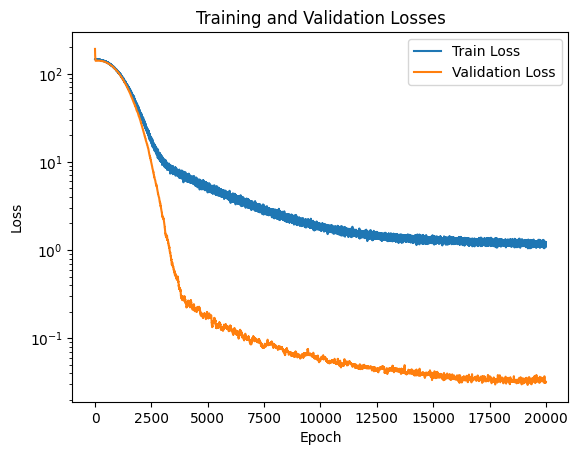

In [25]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')  # Set y-axis scale to logarithmic
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

### 3. Testing

Test R2: 0.8410998925921713
Test RMSE: 38102.66873234792


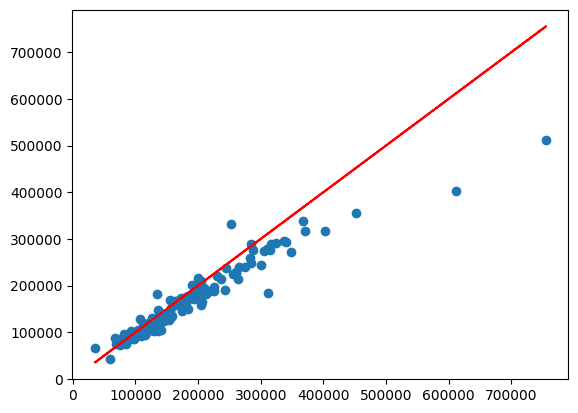

In [27]:
test_preds = []
test_targets = []
model.eval()
with torch.no_grad():
    for cat_inputs, cont_inputs, labels in test_loader:
        outputs = model(cat_inputs, cont_inputs)
        outputs = torch.exp(outputs.squeeze()).detach().numpy()
        test_preds.append(outputs.item())
        
        labels = torch.exp(labels).detach().numpy()
        test_targets.append(labels.item())

test_r2 = r2_score(test_targets, test_preds)
RMSE = np.sqrt(mean_squared_error(test_targets, test_preds))
print(f"Test R2: {test_r2}")
print(f"Test RMSE: {RMSE}")

plt.plot(test_targets, test_targets, color="red")
plt.scatter(test_targets, test_preds)
plt.show()

### 4. Kaggle submission code

In [ ]:
class CustomDataLoader:
    def __init__(self, data, cat_cols=None, cont_cols=None):  
       
        # Preprocess categorical variables 
        cats = []
        for cat in cat_cols:
            data[cat] = data[cat].astype('category')
            vec = data[cat].cat.codes.values
            cats.append(vec)
        self.cats = np.stack(cats, 1)
        
        cat_szs = [len(data[col].cat.categories) for col in cat_cols]
        self.emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
        
        # Preprocess continuous variables
        conts = []
        for con in cont_cols:
            vec = data[con].values
            conts.append(vec)
        self.conts = np.stack(conts, 1)


    def get_data_loaders(self):
        test_dataset = TensorDataset(
            torch.tensor(self.cats, dtype=torch.long), 
            torch.tensor(self.conts, dtype=torch.float32))

        # Create data loaders
        test_loader = DataLoader(test_dataset, shuffle=False)

        return test_loader

filt = df["Id"] < 1461
df1 = df[~filt]

X = df1.drop(columns="SalePrice")
cat_cols = list(df1.select_dtypes(include=['category']).columns)
cont_cols = list(df1.select_dtypes(include=['int', 'float']).columns)
cont_cols.remove("Id")
cont_cols.remove("SalePrice")
custom_loader = CustomDataLoader(X,cat_cols, cont_cols)
test_loader = custom_loader.get_data_loaders()

In [ ]:
test_preds = []
model.eval()
with torch.no_grad():
    for cat_inputs, cont_inputs in test_loader:
        outputs = model(cat_inputs, cont_inputs)
        outputs = torch.exp(outputs.squeeze()).detach().numpy()
        test_preds.append(outputs.item())


In [ ]:
# Create a DataFrame
df_out = pd.DataFrame({
    'Id': range(1461, 1461 + len(test_preds)),
    'SalePrice': test_preds
})

df_out.to_csv('submission.csv', index=False)